## **Predicting Rider Count**

<br></br>
<h3><b> Loading Python Libraries </b></h3>

In [1]:
!pip install ucimlrepo
!pip install lazypredict

In [2]:
# Let's import the required python packages
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import r2_score
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline
# plt.style.use('seaborn-dark')
plt.style.context('grayscale')

<br></br>
### **Importing the Data**

In [3]:
# Let's fetch the bike sharing dataset into a data_frame
bike_sharing_dataset = fetch_ucirepo(id=275)

X = bike_sharing_dataset.data.features
y = bike_sharing_dataset.data.targets

bike_sharing_df = pd.concat([X, y], axis=1)

# Let's take a quick look at the shape of the dataframe
print("Bike Rentals data shape -->", bike_sharing_df.shape)
print()

# Let's take a brief look at the contents of the dataframe
bike_sharing_df.head().style.background_gradient()

Bike Rentals data shape --> (17379, 14)



,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.240000,0.287900,0.810000,0.000000,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.220000,0.272700,0.800000,0.000000,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.220000,0.272700,0.800000,0.000000,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.240000,0.287900,0.750000,0.000000,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.240000,0.287900,0.750000,0.000000,1


<br></br>
<h3><b> Gaining Insights from Data </b></h3>

In [4]:
# Let's obtain a brief overview of the dataframe
bike_sharing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 1.9+ MB


In [5]:
# Let's see descriptive statistics for all numeric columns
bike_sharing_df.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,2.50,0.50,6.54,11.55,0.03,3.00,0.68,1.43,0.50,0.48,0.63,0.19,189.46
std,1.11,0.50,3.44,6.91,0.17,2.01,0.47,0.64,0.19,0.17,0.19,0.12,181.39
min,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.02,0.00,0.00,0.00,1.00
25%,2.00,0.00,4.00,6.00,0.00,1.00,0.00,1.00,0.34,0.33,0.48,0.10,40.00
50%,3.00,1.00,7.00,12.00,0.00,3.00,1.00,1.00,0.50,0.48,0.63,0.19,142.00
75%,3.00,1.00,10.00,18.00,0.00,5.00,1.00,2.00,0.66,0.62,0.78,0.25,281.00
max,4.00,1.00,12.00,23.00,1.00,6.00,1.00,4.00,1.00,1.00,1.00,0.85,977.00


<b><h4>Observations</h4></b>
1. **The cnt variable, representing the count of bike rentals, has a wide range. The minimum is 1, and the maximum is 977, indicating significant variability in the number of bikes rented.**
2. **The season column has a mean close to 2.5, suggesting that the data is fairly evenly distributed across the four seasons.**

<br></br>
### **Data Cleaning**

In [6]:
## Let's drop the unnecessary columns like dteday because dteday is the
## date when experiment was performed.
bike_sharing_df.drop(["dteday"], axis=1, inplace=True)

#### Check Duplicate Values

In [7]:
# Let's check for the duplicate values
bike_sharing_df[bike_sharing_df.duplicated(keep=False)].style.background_gradient()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
7958,4,0,12,6,0,6,0,1,0.240000,0.257600,0.650000,0.104500,11
8126,4,0,12,6,0,6,0,1,0.240000,0.257600,0.650000,0.104500,11
13559,3,1,7,4,0,2,1,1,0.660000,0.606100,0.830000,0.089600,6
13727,3,1,7,4,0,2,1,1,0.660000,0.606100,0.830000,0.089600,6


<br></br>
#### Drop duplicate values

In [8]:
# Let's drop the duplicate values from the dataframe
bike_sharing_df = bike_sharing_df.drop_duplicates()

In [9]:
# Let's take a quick look at the shape of the dataframe
print("Bike Sharing data shape -->", bike_sharing_df.shape)
print()

# Let's take a brief look at the contents of the dataframe
bike_sharing_df.head().style.background_gradient()

Bike Sharing data shape --> (17377, 13)



,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.240000,0.287900,0.810000,0.000000,16
1,1,0,1,1,0,6,0,1,0.220000,0.272700,0.800000,0.000000,40
2,1,0,1,2,0,6,0,1,0.220000,0.272700,0.800000,0.000000,32
3,1,0,1,3,0,6,0,1,0.240000,0.287900,0.750000,0.000000,13
4,1,0,1,4,0,6,0,1,0.240000,0.287900,0.750000,0.000000,1


<br></br>

In [10]:
# Function to get unique_counts based on specific column
def value_counts(column_name):
    return bike_sharing_df.loc[
        :, column_name
    ].value_counts()  # Returns the unique value counts

In [11]:
# Iterates over all the columns of the dataframe and calls value_counts func
required_columns = [
    "season",
    "yr",
    "mnth",
    "holiday",
]
for column_name in required_columns:
    print(f"Value Counts of {column_name}")
    value_counts_data = value_counts(column_name=column_name)
    for index, value in value_counts_data.items():
        print(f"{column_name} {index}: {value}")
    print()


Value Counts of season
season 3: 4495
season 2: 4409
season 1: 4242
season 4: 4231

Value Counts of yr
yr 1: 8733
yr 0: 8644

Value Counts of mnth
mnth 5: 1488
mnth 7: 1487
mnth 12: 1482
mnth 8: 1475
mnth 3: 1473
mnth 10: 1451
mnth 6: 1440
mnth 4: 1437
mnth 9: 1437
mnth 11: 1437
mnth 1: 1429
mnth 2: 1341

Value Counts of holiday
holiday 0: 16877
holiday 1: 500



<br></br>
### **See how many missing data points we have**

In [12]:
bike_sharing_df.isnull().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

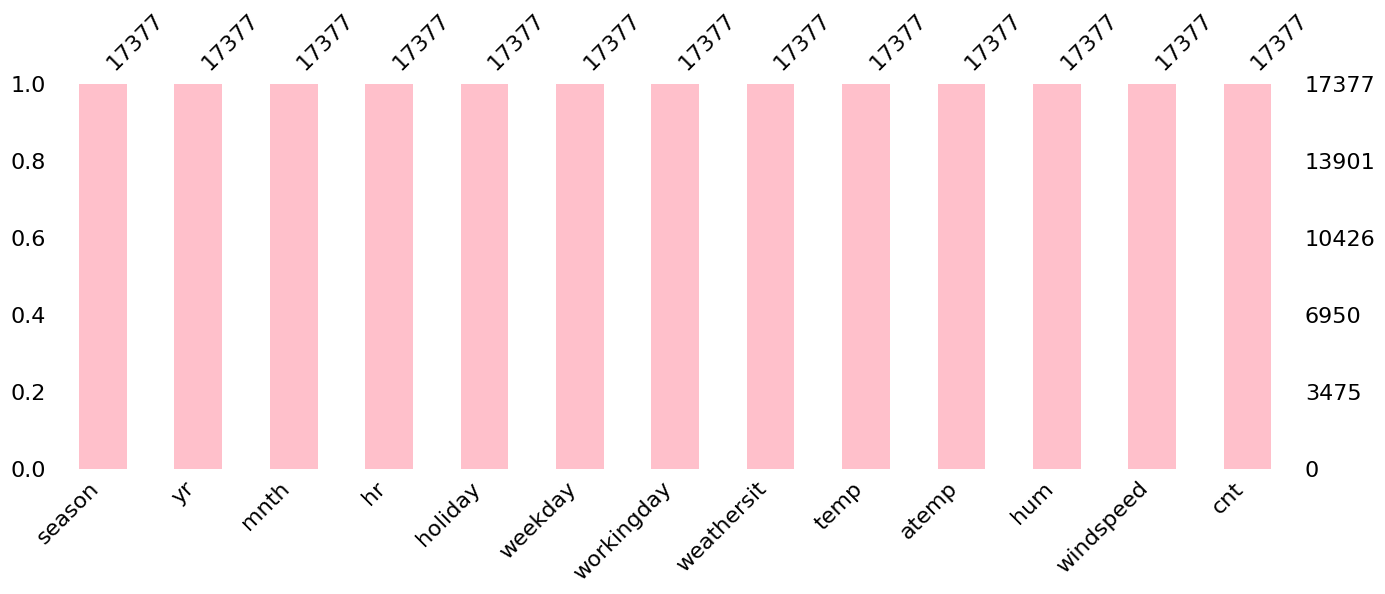

In [13]:
msno.bar(bike_sharing_df, figsize = (16,5),color = "pink")
plt.show()

<br></br>
<h3><b> Exploratory Data Analysis</b></h3>

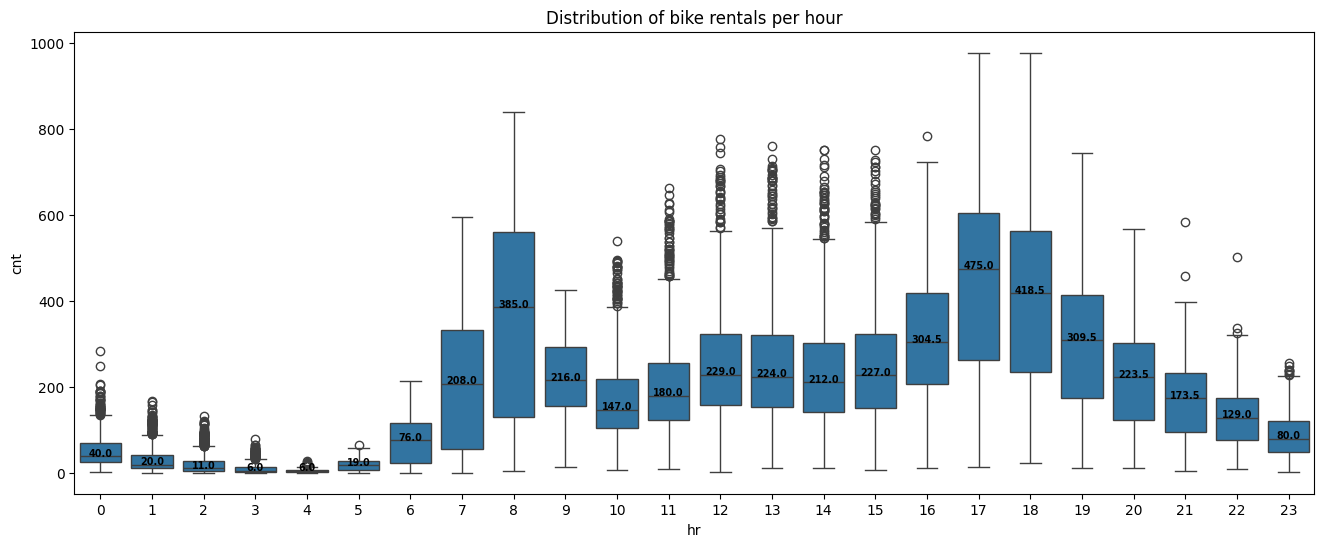

In [14]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="hr", y="cnt", data=bike_sharing_df)
plt.title("Distribution of bike rentals per hour")

# Annotating the median value of each box
medians = bike_sharing_df.groupby(['hr'])['cnt'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]

pos = range(len(medians))
for tick, label in zip(pos, ax.get_xticks()):
    ax.text(pos[tick], medians[tick] + 0.03, median_labels[tick],
            horizontalalignment='center', size='x-small', color='black', weight='semibold')

plt.show()

Text(0.5, 1.0, 'Distribution of bike rentals V/S days of the week')

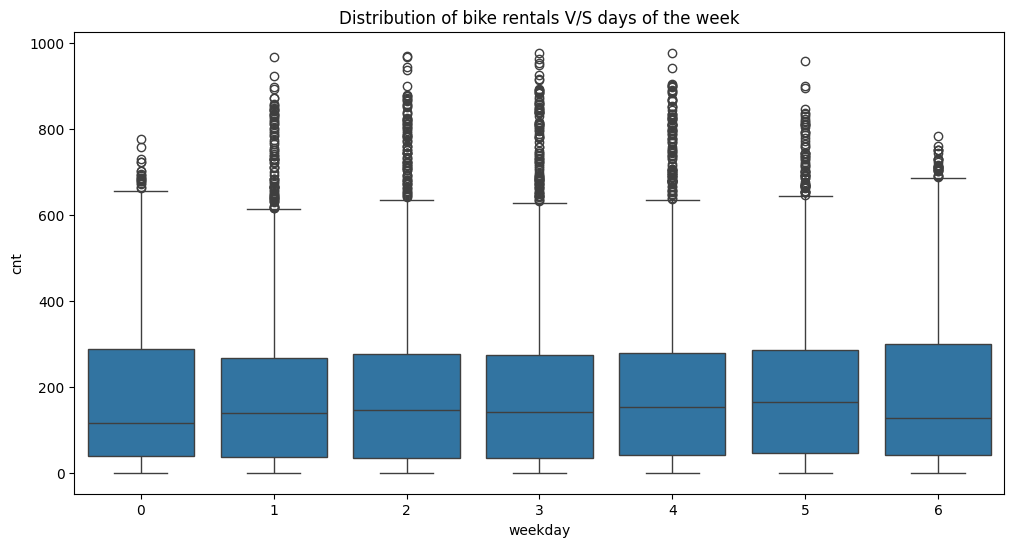

In [15]:
plt.figure(figsize=(12,6))
sns.boxplot(x="weekday", y="cnt", data=bike_sharing_df)
plt.title("Distribution of bike rentals V/S days of the week")

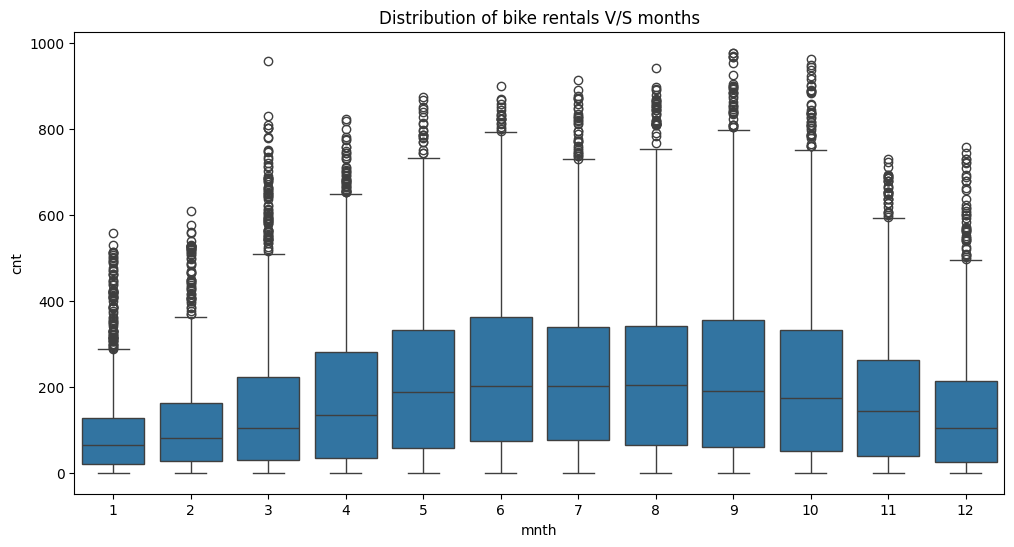

In [16]:
plt.figure(figsize=(12,6))
sns.boxplot(x="mnth", y="cnt", data=bike_sharing_df)
plt.title("Distribution of bike rentals V/S months")
plt.show()

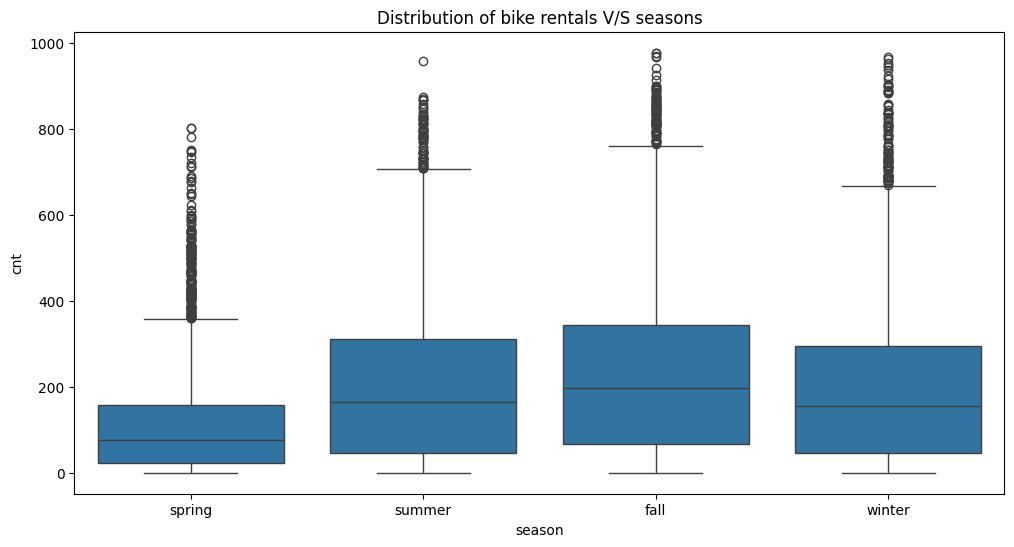

In [17]:
bike_sharing_df_plot = bike_sharing_df.copy()
bike_sharing_df_plot['season'] = bike_sharing_df_plot["season"].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
plt.figure(figsize=(12,6))
sns.boxplot(x='season', y='cnt', data=bike_sharing_df_plot)
plt.title('Distribution of bike rentals V/S seasons')
plt.show()

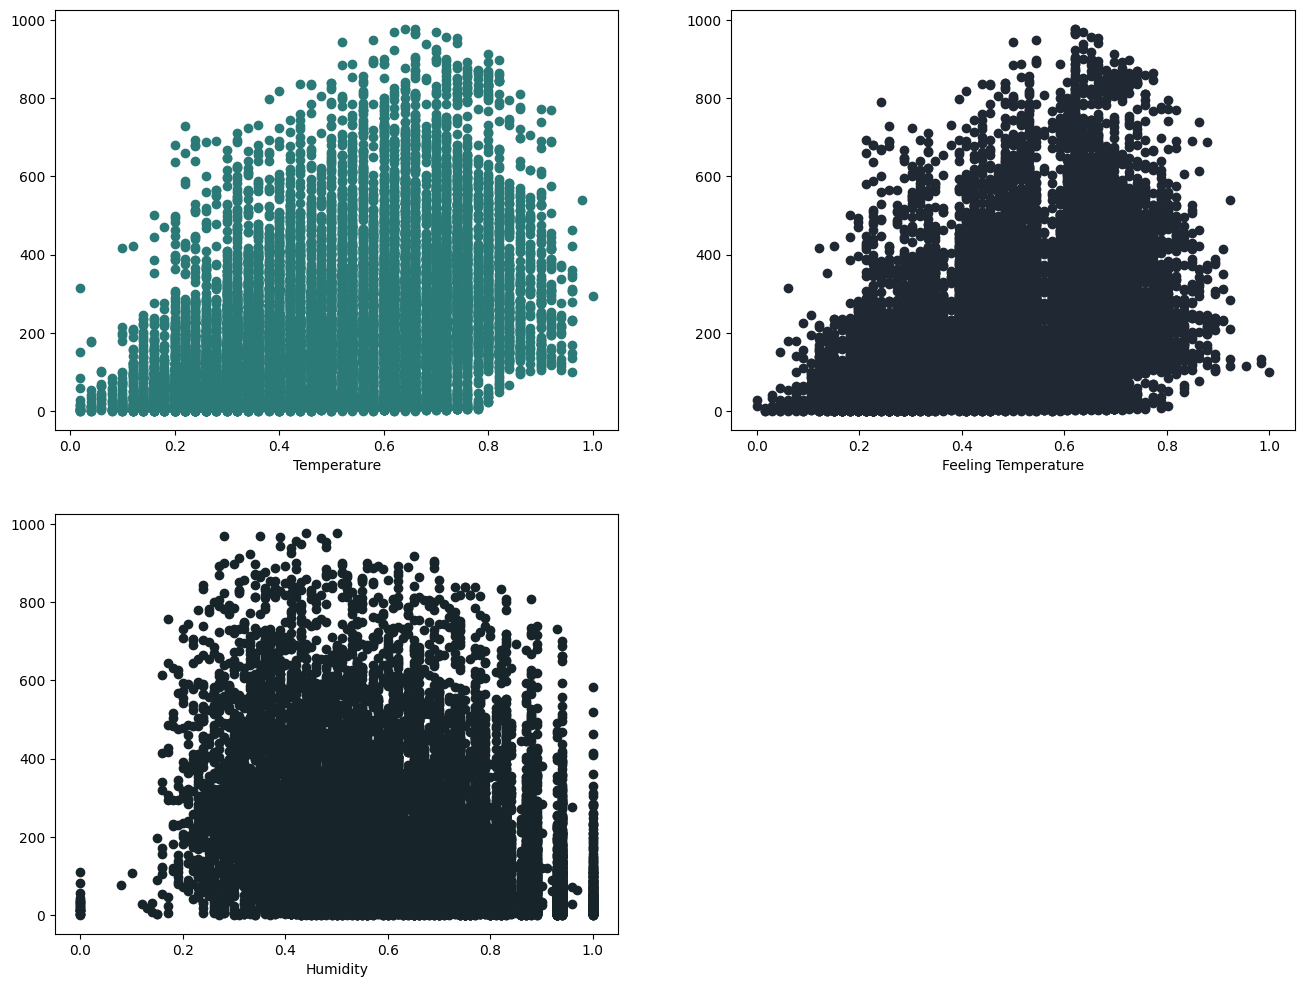

In [18]:
# Visualizing the Numerical Columns (Hidden Input) and treating outliers

plt.figure(figsize=[16,12])
plt.subplot(2,2,1)
plt.scatter(x=bike_sharing_df['temp'], y=bike_sharing_df['cnt'], c="#2b7a78")
plt.xlabel("Temperature")
plt.grid(False)
plt.subplot(2,2,2)
plt.scatter( x=bike_sharing_df['atemp'], y=bike_sharing_df['cnt'], c='#1f2833')
plt.xlabel("Feeling Temperature")
plt.grid(False)
plt.subplot(2,2,3)
plt.scatter( x=bike_sharing_df['hum'], y=bike_sharing_df['cnt'], c='#17252a')
plt.xlabel("Humidity")
plt.grid(False)


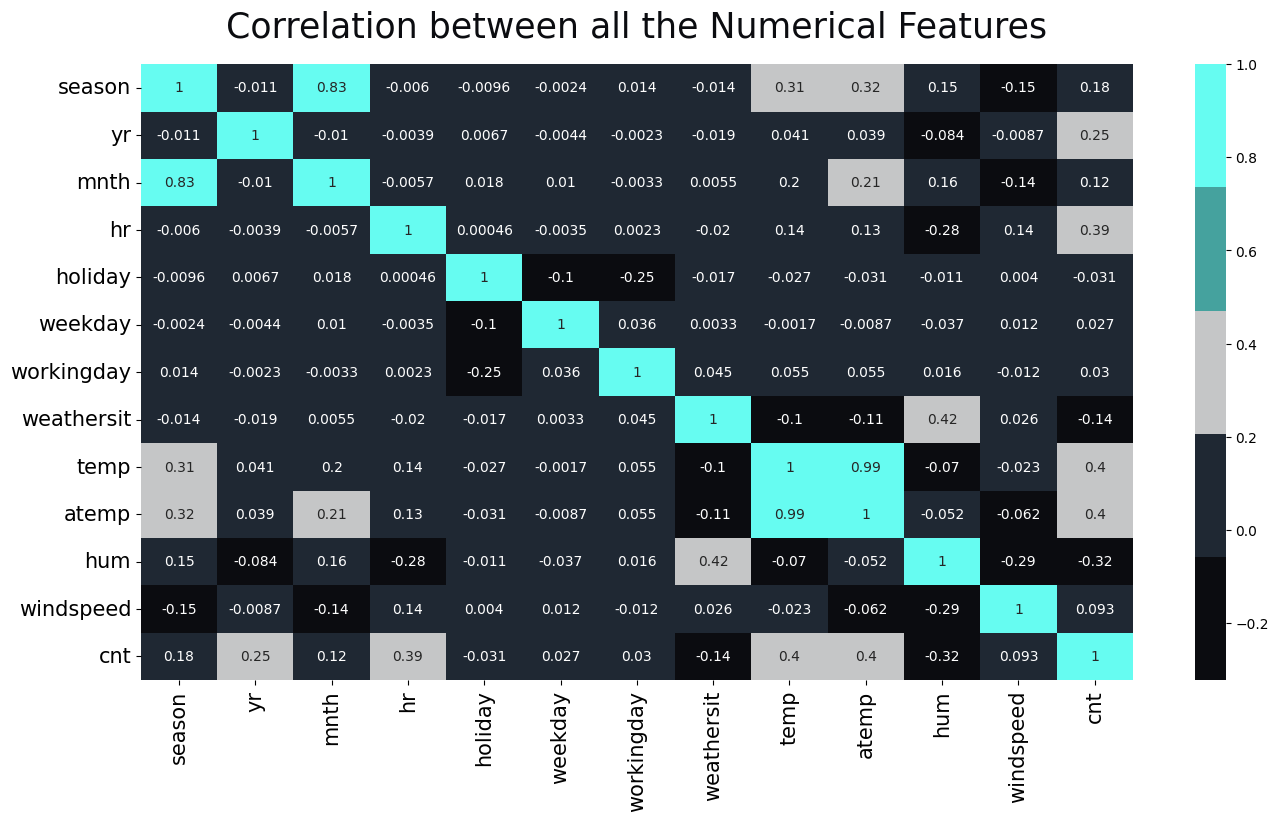

In [19]:
heat = bike_sharing_df.corr()
plt.figure(figsize=[16,8])
plt.title("Correlation between all the Numerical Features", size=25, pad=20, color='#0b0c10')
sns.heatmap(heat, cmap=['#0b0c10', '#1f2833','#c5c6c7','#45a29e','#66fcf1'], annot=True)
plt.xticks(size=15)
plt.yticks(size=15, rotation=360)
plt.show()

<br></br>
<b><h3> Data Split </h3></b>

In [20]:
# Let's split the data into X and y
y = bike_sharing_df.pop('cnt')
X = bike_sharing_df

# Performing the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=69)


<br></br>
<b><h3> Data Normalization </h3></b>

In [21]:
# Normalizing our data...

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

<br></br>
<b><h3> Comparing Performance of Different Models </h3></b>

In [22]:
model = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = model.fit(X_train, X_test, y_train, y_test)
print(models)

 79%|███████▊  | 33/42 [01:50<00:12,  1.39s/it]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [02:07<00:00,  3.02s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 12163, number of used features: 12
[LightGBM] [Info] Start training from score 189.227822
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
XGBRegressor                                 0.95       0.95  39.90   
ExtraTreesRegressor                          0.95       0.95  40.46   
HistGradientBoostingRegressor                0.95       0.95  41.07   
LGBMRegressor                                0.95       0.95  41.28   
RandomForestRegressor                        0.95       0.95  41.97   
BaggingRegressor                             0.94       0.94  44.19   
DecisionTreeRegressor    

<br></br>
<b><h3> Model Building(ML) </h3></b>

In [23]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
y_pred = xgb_regressor.predict(X_test)
print("R2 score on test data: ", r2_score(y_true=y_test, y_pred=y_pred))

R2 score on test data:  0.9522321207805912


<br></br>
<b><h3> Hyperparameter Tuning with Grid Search </h3></b>

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800, 1000, 1200],
    'learning_rate': [0.01, 0.05, 0.06, 0.07, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    # Add more parameters here
}

xgb_regressor = XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Best parameters: {'learning_rate': 0.06, 'max_depth': 8, 'n_estimators': 300}


In [26]:
xgb_regressor = XGBRegressor(learning_rate=0.06, max_depth=8, n_estimators=300)
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [27]:
y_pred = xgb_regressor.predict(X_test)
print("R2 score on test data: ", r2_score(y_true=y_test, y_pred=y_pred))

R2 score on test data:  0.9552281426618424


<br></br>
<b><h3> Model Building(Neural Networks) </h3></b>

In [28]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [29]:
import keras.backend as K
from keras.layers import Dense
from keras.models import Sequential

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Custom Metric for RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

<br></br>
#### Neural Network Architecture
- **Model**: Sequential 3-layer network.
- **Layers**:
  - Dense layer with 64 neurons, ReLU activation (Input layer).
  - Two Dense layers with 128 neurons each, ReLU activation.
  - Output Dense layer with 1 neuron, linear activation.


#### Training
- **Epochs**: 100
- **Batch size**: 32
- **Training R2 score**: 0.9411
- **Validation R2 score**: 0.9342


In [30]:
# Let's train the model
# Define the model
model_3_layer = Sequential()
model_3_layer.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_3_layer.add(Dense(128, activation='relu'))
model_3_layer.add(Dense(128, activation='relu'))
model_3_layer.add(Dense(1, activation='linear'))

# Compile the model
model_3_layer.compile(loss=root_mean_squared_error,
              optimizer='adam',
              metrics=[root_mean_squared_error, r_squared])

# Summary of the model
model_3_layer.summary()
model_3_layer_regressor = model_3_layer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 25793 (100.75 KB)
Trainable params: 25793 (100.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
381/381 [==============================] - 7s 5ms/step - loss: 166.0716 - root_mean_squared_error: 166.2390 - r_squared: 0.0141 - val_loss

In [31]:
# Predictions on Test Data
test_predictions = model_3_layer.predict(X_test)

test_r2_score = r2_score(y_test, test_predictions)
print("3 Layer ANN, Test R2 Score:", test_r2_score)

163/163 [==============================] - 0s 1ms/step
3 Layer ANN, Test R2 Score: 0.9420452334260017


<br></br>
#### Neural Network Architecture
- **Model**: Sequential 5-layer network.
- **Layers**:
  - Dense layer with 64 neurons, ReLU activation (Input layer).
  - Two Dense layers with 128 neurons each, ReLU activation.
  - Dense layer with 64 neurons, ReLU activation.
  - Dense layer with 32 neurons, ReLU activation.
  - Output Dense layer with 1 neuron, linear activation.


#### Training
- **Epochs**: 100
- **Batch size**: 32
- **Training R2 score**: 0.9545
- **Validation R2 score**: 0.9373


In [32]:
# Let's train the model
# Define the model
model_5_layer = Sequential()
model_5_layer.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_5_layer.add(Dense(128, activation='relu'))
model_5_layer.add(Dense(128, activation='relu'))
model_5_layer.add(Dense(64, activation='relu'))
model_5_layer.add(Dense(32, activation='relu'))
model_5_layer.add(Dense(1, activation='linear'))

# Compile the model
model_5_layer.compile(loss=root_mean_squared_error,
              optimizer='adam',
              metrics=[root_mean_squared_error, r_squared])

# Summary of the model
model_5_layer.summary()
model_5_layer_regressor = model_5_layer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                832       
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 36033 (140.75 KB)
Trainable params: 3603

In [33]:
# Predictions on Test Data
test_predictions = model_5_layer.predict(X_test)

test_r2_score = r2_score(y_test, test_predictions)
print("5 Layer ANN, Test R2 Score:", test_r2_score)

163/163 [==============================] - 0s 2ms/step
5 Layer ANN, Test R2 Score: 0.952174006713812


<br></br>
#### Neural Network Architecture
- **Model**: Sequential 7-layer network.
- **Layers**:
  - Dense layer with 64 neurons, ReLU activation (Input layer).
  - Three Dense layers with 128 neurons each, ReLU activation.
  - Two  Dense layers with 64 neurons each, ReLU activation.
  - Dense layer with 32 neurons, ReLU activation.
  - Output Dense layer with 1 neuron, linear activation.


#### Training
- **Epochs**: 250
- **Batch size**: 32
- **Training R2 score**: 0.9822
- **Validation R2 score**: 0.9452


In [34]:
# Let's train the model
# Define the model
model_7_layer = Sequential()
model_7_layer.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_7_layer.add(Dense(128, activation='relu'))
model_7_layer.add(Dense(128, activation='relu'))
model_7_layer.add(Dense(128, activation='relu'))
model_7_layer.add(Dense(64, activation='relu'))
model_7_layer.add(Dense(64, activation='relu'))
model_7_layer.add(Dense(32, activation='relu'))
model_7_layer.add(Dense(1, activation='linear'))

# Compile the model
model_7_layer.compile(loss=root_mean_squared_error,
              optimizer='adam',
              metrics=[root_mean_squared_error, r_squared])

# Summary of the model
model_7_layer.summary()
model_7_layer_regressor = model_7_layer.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=250, batch_size=32)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                832       
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 32)               

In [35]:
# Predictions on Test Data
test_predictions = model_7_layer.predict(X_test)

test_r2_score = r2_score(y_test, test_predictions)
print("7 Layer ANN, Test R2 Score:", test_r2_score)

163/163 [==============================] - 0s 2ms/step
7 Layer ANN, Test R2 Score: 0.9510664399181744
